In [92]:
from typing import Annotated,TypedDict
from dotenv import load_dotenv
import gradio as gr
import random
from pydantic import BaseModel
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages,BaseMessage
from langchain_openai import ChatOpenAI


In [77]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [78]:
load_dotenv(override=True)

True

1) Define the STATE object with pydantic model or Typedict

   But LangGraph's recc. is using Typeddict

In [79]:
#Either use this --> Langgraph Reccomended(Faster because No validation)

#TypedDict version -> A list of chat message objects (HumanMessage, AIMessage, etc.)
#LangGraph expects the agent state to be dict-like
#Messages are stored as actual objects (HumanMessage, AIMessage, etc) in BaseMessage
# and add_messages is a reducer function which is appends new messages instead of overriding 
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]


In [80]:
# or Use this -> If we need pydantic validation (little slow because it validates what we passeed,automatic type conversion like "25" will be converted to int -> 25)

class State1(BaseModel):
    messages:Annotated[list,add_messages]

#here one thing is we are not using list[BaseMessage] like we used in TypedDict 
#the reason is You could even write messages: list[BaseMessage] in Pydantic, but then the input must be actual BaseMessage objects, which may be too strict for API inputs.
# while passing in api it will raise error so we have to accept generic like only list then if needed we can convert
#Another overhead if list has some string or something where sometimes actual like anything humanmessage or something it misses it will throws error which is overhead for us
# So use only list and not list[BaseMessage] while using Pydantic's BaseModel which is very strict 

2) Start the graph builder with this State Class

In [81]:
graph_builder = StateGraph(State)

3. Create a Node

In [82]:
def first_node(old_state: State)-> State:
    content =f'{random.choice(nouns)} are {random.choice(adjectives)}'
    messages =[{"role":"assistant","content":content}]
    
    new_state =State(messages=messages)
    #print(content)
    return new_state

first_node('a')

{'messages': [{'role': 'assistant', 'content': 'Cabbages are existential'}]}

4) Add Nodes and Edges

In [83]:
#add Nodes
graph_builder.add_node("1st_node",first_node)

#add Edges
graph_builder.add_edge(START,"1st_node")
graph_builder.add_edge("1st_node",END)

5. Compile the graph

In [84]:
graph =graph_builder.compile()

6) Display the Graph

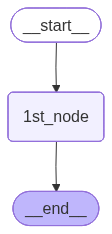

In [85]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [91]:
def chat(user_input:str,history):
    message =[{"role":"user","content":user_input}]

    messages=message
    state=State(messages=messages)
    result =graph.invoke(state)
    print(result)
    #return result
    return result['messages'][-1].content

gr.ChatInterface(chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='5622ee9a-1636-40e3-aa92-03ab9a323ba3'), AIMessage(content='Rainbows are squishy', additional_kwargs={}, response_metadata={}, id='2c54ba03-e137-4b18-a624-e6a28ba04ef9')]}
{'messages': [HumanMessage(content='hll', additional_kwargs={}, response_metadata={}, id='9e73268e-4379-437e-be58-72997fd401b6'), AIMessage(content='Muffins are existential', additional_kwargs={}, response_metadata={}, id='8eb3a46f-c4ee-42e5-b907-fbd672f19e12')]}
{'messages': [HumanMessage(content='how are u', additional_kwargs={}, response_metadata={}, id='721050c2-e0dd-42da-a65b-6bbb15ddfca3'), AIMessage(content='Muffins are outrageous', additional_kwargs={}, response_metadata={}, id='1950a78a-d155-4ef6-b07a-499d371e622b')]}


Add llm now 

In [172]:
class State(BaseModel):
    messages:Annotated[list,add_messages]

In [173]:
graph_builder =StateGraph(State)

In [ ]:
# add llm

llm=ChatOpenAI(model="gpt-3.5-turbo")

def chatbot(old_state:State)->State: 
    print("old_state:",old_state) #eg hi there + other things like id etc (where i entered currently in gradio ui)
    response =llm.invoke(old_state.messages) 
    print("response is ",response)
    new_state =State(messages=[response])
    print("a new state:",new_state)
    return new_state

In [175]:
graph_builder.add_node("chatbot_node",chatbot)

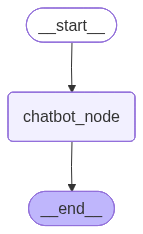

In [176]:
graph_builder.add_edge(START,"chatbot_node")
graph_builder.add_edge("chatbot_node",END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [177]:
def chat(user_input:str,history):
    initial_state =State(messages=[{"role":"user","content":user_input}])
    result =graph.invoke(initial_state)
    print("whole result:",result)
    return result['messages'][-1].content
    

In [ ]:
gr.ChatInterface(chat,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.


old_state: messages=[HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='ae69d61f-184a-4998-a45b-97caa3330cb8')]
response is  content='Hello! How can I help you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CRMAqlkJ81OujhreEgFfMV8kcNfg3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--bdb16644-3c5b-4331-bce2-4ff08ffdf869-0' usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
a new state: messages=[AIMessage(content='Hello